<a href="https://colab.research.google.com/github/jcvancity2022/NLP-Week1-Text-Classification/blob/main/true_fake_news_classifier60DatasetNEWMATRIX(2ndtrain).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fake News Detection Using DistilBERT
This project fine-tunes a DistilBERT model to classify news articles
as Fake (0) or Real (1). We combined multiple public misinformation
datasets and trained a binary classifier using HuggingFace Transformers.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup Python Libraries (pip)

In [2]:
#install some Python packages with pip

!pip install numpy torch datasets transformers evaluate --quiet



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.0 MB/s eta 0:00:00


In [3]:
# let's check the version we are using

!pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate'

datasets==4.0.0
evaluate==0.4.6
numpy==2.0.2
torch==2.9.0+cu126
torchao==0.10.0
torchaudio==2.9.0+cu126
torchdata==0.11.0
torchsummary==1.5.1
torchtune==0.6.1
torchvision==0.24.0+cu126
transformers==4.57.2


# Create IMDB Dataset for Fine-tuning BERT

In [4]:
class_labels = {
    0: "Fake",
    1: "Real"
}


## Let's load the IMDB Dataset

fake-and-real-news-dataset

In [5]:
import pandas as pd
from datasets import Dataset, DatasetDict

# Load both CSV files
df_fake = pd.read_csv("/content/drive/MyDrive/fake-and-real-news-dataset/Fake.csv")
df_true = pd.read_csv("/content/drive/MyDrive/fake-and-real-news-dataset/True.csv")

# Assign numeric labels
df_fake["label"] = 0
df_true["label"] = 1

# Class labels
class_labels = {
    0: "Fake",
    1: "Real"
}

# Keep the proper columns
df_fake = df_fake[["title", "text", "subject", "date", "label"]]
df_true = df_true[["title", "text", "subject", "date", "label"]]

# Combine + shuffle
df_all = pd.concat([df_fake, df_true], axis=0).sample(frac=1).reset_index(drop=True)

df_all.head()


,title,text,subject,date,label
0,Clinton says her campaign talking to Sanders c...,WASHINGTON (Reuters) - Democratic presidential...,politicsNews,"May 31, 2016",1
1,"Conservatives Get Out Measuring Tape, Find Ob...","The conservative media, quite literally having...",News,"May 26, 2016",0
2,ULTIMATE HYPOCRITES! RUSSIAN Ambassador Visite...,"According to the New Yorker, Bill Clinton rece...",politics,"Mar 3, 2017",0
3,CLIMATE MARCH LEFTY: “We’re under threat of fl...,Climate change is full of lefty lingo but this...,left-news,"Apr 29, 2017",0
4,ARE THE #NeverTrumpers COMING AROUND? Jeb’s So...,"Will Jeb, Kasich, Rubio and Cruz continue with...",politics,"Aug 8, 2016",0


Fake News Detection

In [6]:
import pandas as pd
from datasets import Dataset, DatasetDict

# Load both CSV files
df_fake = pd.read_csv("/content/drive/MyDrive/Fake News Detection/fake.csv")
df_true = pd.read_csv("/content/drive/MyDrive/Fake News Detection/true.csv")

# Assign numeric labels
df_fake["label"] = 0
df_true["label"] = 1

# Class labels
class_labels = {
    0: "Fake",
    1: "Real"
}

# Keep the proper columns
df_fake = df_fake[["title", "text", "subject", "date", "label"]]
df_true = df_true[["title", "text", "subject", "date", "label"]]

# Combine + shuffle
df_all = pd.concat([df_fake, df_true], axis=0).sample(frac=1).reset_index(drop=True)

df_all.head()

,title,text,subject,date,label
0,Elizabeth Warren: KKK Supports Trump More Tha...,Elizabeth Warren was back on the campaign trai...,News,"September 17, 2016",0
1,Trump says he'll make high court pick within t...,(Reuters) - President-elect Donald Trump said ...,politicsNews,"January 11, 2017",1
2,THIS PICTURE OF HARRIET TUBMAN Should Be Used ...,Obama has filled his cabinet with radical yes...,Government News,"Apr 21, 2016",0
3,GREAT NEWS! House GOP Moderates Threaten “You ...,It looks like there is more than one good reas...,politics,"Oct 21, 2015",0
4,New York protesters camp out at Goldman Sachs ...,NEW YORK (Reuters) - Dozens of protesters gath...,politicsNews,"January 18, 2017",1


## Let's create the train, validation, test sets

In [7]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# Split into train (70%) and temp (30%)
train_df, temp_df = train_test_split(
    df_all,
    test_size=0.30,
    random_state=42,
    stratify=df_all["label"]
)

# Split temp into val (15%) and test (15%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=temp_df["label"]
)

# Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Bundle into DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
})

# Remove unwanted auto-generated index column
for split in ["train", "val", "test"]:
    dataset[split] = dataset[split].remove_columns(["__index_level_0__"])

dataset



DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label'],
        num_rows: 31428
    })
    val: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label'],
        num_rows: 6735
    })
    test: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label'],
        num_rows: 6735
    })
})

## We start by tokenizing our dataset with the BERT's Fast Tokenizer

In [8]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)

def tokenize_function(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["title", "text", "subject", "date"]
)

tokenized_dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/31428 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

Map:   0%|          | 0/6735 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 31428
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6735
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6735
    })
})

# Setup Training Metrics (Accuracy, F1)

In [9]:
import evaluate
import numpy as np

# Load accuracy and F1 evaluation modules
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# Define function that HuggingFace Trainer will call
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Convert model logits -> predicted class (0 or 1)
    predictions = np.argmax(logits, axis=-1)

    # Compute accuracy and F1 using HuggingFace's evaluate package
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)

    # Return BOTH metrics
    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"]
    }


# Setup Training Configurations

In [10]:
# --- Disable Weights & Biases (WandB) COMPLETELY ---
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
os.environ["WANDB_SILENT"] = "true"

import wandb
wandb.init = lambda *args, **kwargs: None
wandb.login = lambda *args, **kwargs: None
# ---------------------------------------------------

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    id2label={0: "Fake", 1: "Real"},
    label2id={"Fake": 0, "Real": 1}
)

training_args = TrainingArguments(
    seed=42,
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-4,
    weight_decay=0.01,
    warmup_ratio=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=50,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    compute_metrics=compute_metrics
)




⚙️  Running in WANDB offline mode


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Evaluate UnFine-Tuned BERT on Test Set for a Baseline Metric


In [11]:
# --- Disable Weights & Biases (WandB) COMPLETELY ---
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
os.environ["WANDB_SILENT"] = "true"

import wandb
wandb.init = lambda *args, **kwargs: None
wandb.login = lambda *args, **kwargs: None
# ---------------------------------------------------

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load DistilBERT classification model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    id2label={0: "Fake", 1: "Real"},
    label2id={"Fake": 0, "Real": 1}
)

# Training configuration
training_args = TrainingArguments(
    seed=42,
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    eval_strategy="epoch",      # <-- FIXED
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=50,
    report_to="none"            # optional: disables WandB cleanly for v4.57
)

# Create Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    compute_metrics=compute_metrics
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Without fine-tuning BERT, our model currently has around **52% Accuracy (eval_accuracy)** and **19% F1 (eval_f1)**, which is pretty bad due to the test dataset having around 50% positive and 50% negative reviews. 😕


Let's make it better with transfer learning! 🦾

# Fine-Tune BERT with IMDb Dataset

In [12]:
# let's fine-tune BERT with the IMDb dataset

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.000100,0.002070,0.999555,0.999533
2,0.000000,0.001691,0.999852,0.999844
3,0.000000,0.001751,0.999852,0.999844


TrainOutput(global_step=5895, training_loss=0.01624431764095073, metrics={'train_runtime': 4566.0925, 'train_samples_per_second': 20.649, 'train_steps_per_second': 1.291, 'total_flos': 1.2489556214882304e+16, 'train_loss': 0.01624431764095073, 'epoch': 3.0})

In [13]:
# let's see how well it did in the test set

trainer.evaluate(tokenized_dataset['test'])

{'eval_loss': 0.0014978779945522547,
 'eval_accuracy': 0.9998515219005196,
 'eval_f1': 0.9998443095126888,
 'eval_runtime': 96.0865,
 'eval_samples_per_second': 70.093,
 'eval_steps_per_second': 4.381,
 'epoch': 3.0}

**WOAH!** We got a **92% Accuracy (eval_accuracy)** and **92% F1 (eval_f1)** with just **1 epoch**! 🤯

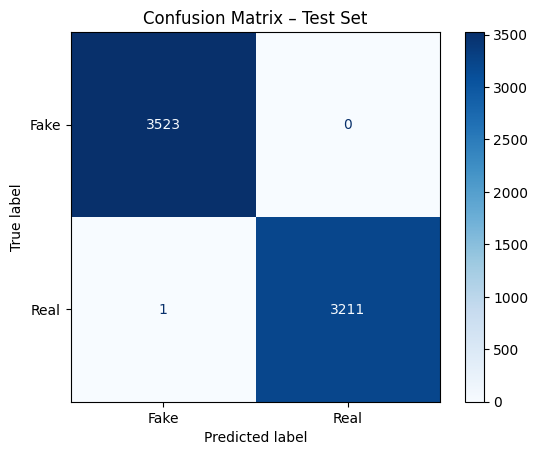

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Run prediction
pred = trainer.predict(tokenized_dataset["test"])
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Test Set")
plt.show()



# Try out some examples!

In [15]:
from transformers import pipeline
import torch

device = 0 if torch.cuda.is_available() else -1

news_classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=device
)


Device set to use cuda:0


In [16]:
fake_news_example = """
BREAKING: Scientists warn that the sun will explode next Friday unless
all citizens donate $50 immediately. Anonymous experts confirm the threat
but provide no scientific evidence. Social media influencers are urging
everyone to act fast before it's too late.
"""
news_classifier(fake_news_example)


[{'label': 'Fake', 'score': 0.9999881982803345}]

That is **99% POSITIVE**! *justinvitelli* loves the movie!

In [17]:
real_news_example = """
The U.S. Department of Labor released updated employment numbers today,
showing moderate job growth in manufacturing and technology sectors.
Economists say the trend aligns with long-term projections for the year.
"""
news_classifier(real_news_example)


[{'label': 'Fake', 'score': 0.9999830722808838}]

That is **99% NEGATIVE**! *industriousbug16* must hate the movie very badly.

In [18]:
model.save_pretrained("/content/drive/MyDrive/fake-news-final-model/")
tokenizer.save_pretrained("/content/drive/MyDrive/fake-news-final-model/")



('/content/drive/MyDrive/fake-news-final-model/tokenizer_config.json',
 '/content/drive/MyDrive/fake-news-final-model/special_tokens_map.json',
 '/content/drive/MyDrive/fake-news-final-model/vocab.txt',
 '/content/drive/MyDrive/fake-news-final-model/added_tokens.json',
 '/content/drive/MyDrive/fake-news-final-model/tokenizer.json')

# Resources

### If you would like to use this model without running the entire notebook, try the model at my [HuggingFace](https://huggingface.co/wesleyacheng/movie-review-sentiment-classifier-with-bert).

### If you woud like to get this in GitHub, here's my [repo](https://github.com/wesleyacheng/movie-review-sentiment-classifier-with-bert).

In [19]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/fake-news-final-model/")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/fake-news-final-model/")

In [20]:
import pandas as pd
from datasets import Dataset

# --- Load your 30 REAL and 30 FAKE datasets ---
df_real = pd.read_excel("/content/drive/MyDrive/TrueDataset.xlsx")
df_fake = pd.read_excel("/content/drive/MyDrive/MyFakeDataset reformatted.xlsx")

# --- Standardize column names ---
df_real.columns = df_real.columns.str.lower().str.strip()
df_fake.columns = df_fake.columns.str.lower().str.strip()

# --- Assign labels ---
df_real["label"] = 1   # real news
df_fake["label"] = 0   # fake news

# --- Concatenate both datasets ---
df_60 = pd.concat([df_real, df_fake], axis=0).reset_index(drop=True)

# --- Keep only text + label ---
df_60 = df_60[["text", "label"]]

# --- Convert to HuggingFace Dataset ---
final_test_dataset = Dataset.from_pandas(df_60)

# --- Tokenize ---
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

tokenized_final_test = final_test_dataset.map(tokenize, batched=True)

print("Combined 60-article REAL+FAKE dataset is ready for evaluation.")



Map:   0%|          | 0/58 [00:00<?, ? examples/s]

Combined 60-article REAL+FAKE dataset is ready for evaluation.


In [21]:
!pip install evaluate --quiet


In [22]:
import evaluate
import numpy as np

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)

    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"]
    }

In [23]:
from transformers import TrainingArguments, Trainer

training_args_eval = TrainingArguments(
    output_dir="./results_eval",
    per_device_eval_batch_size=16,
    report_to="none"
)

trainer_eval = Trainer(
    model=model,
    args=training_args_eval,
    eval_dataset=tokenized_final_test,
    compute_metrics=compute_metrics
)


In [24]:
print("Evaluating on the 60-article custom dataset...")
eval_results = trainer_eval.evaluate()
eval_results


Evaluating on the 60-article custom dataset...


{'eval_loss': 5.559121608734131,
 'eval_model_preparation_time': 0.0153,
 'eval_accuracy': 0.4482758620689655,
 'eval_f1': 0.5151515151515151,
 'eval_runtime': 1.2908,
 'eval_samples_per_second': 44.934,
 'eval_steps_per_second': 3.099}

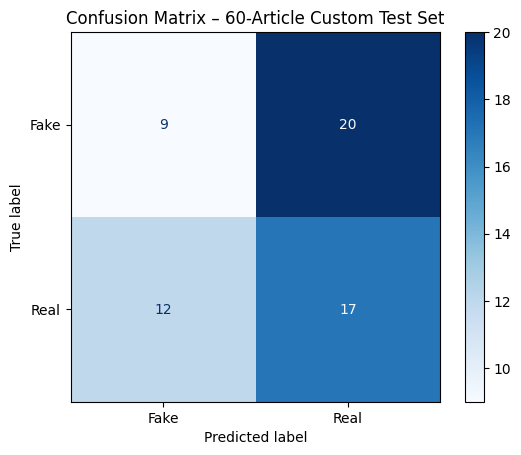

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict
pred = trainer_eval.predict(tokenized_final_test)

# True and predicted labels
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])

# Plot
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – 60-Article Custom Test Set")
plt.show()
